In [213]:
import numpy as np

In [214]:
import os

In [381]:
import numpy as np

# metric
def metric(label, pred):
    assert label.shape == pred.shape
    
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        mask = np.not_equal(label, 0)
        mask = mask.astype(np.float32)
        mask /= np.mean(mask)
        male = np.abs(np.subtract(np.log(pred), np.log(label))).astype(np.float32)
        male = np.nan_to_num(male * mask)
        male = np.mean(male)
        mae = np.abs(np.subtract(pred, label)).astype(np.float32)
        rmse = np.square(mae)
        mape = np.divide(mae, label)
        mae = np.nan_to_num(mae * mask)
        mae = np.mean(mae)
        rmse = np.nan_to_num(rmse * mask)
        rmse = np.sqrt(np.mean(rmse))
        mape = np.nan_to_num(mape * mask)
        mape = np.median(mape) # np.mean(mape) -- author leverages median
    return male, rmse, mape*100


In [382]:
datasets = ['fc', 'kc', 'sp', 'poa']

In [383]:
dname = datasets[0]

In [384]:
os.listdir('fc')

['fc_AMMASI_64_0.2_0.1_loc_True_poi_False.npy',
 'fc_AMMASI_64_0.02_0.1_loc_False_poi_True.npy',
 'fc_AMMASI_64_0.05_0.02_loc_Sinusoidal_poi_True.npy',
 'fc_AMMASI_64_0.1_0.2_loc_Sinusoidal_poi_False.npy',
 'fc_AMMASI_64_0.05_0.03_loc_True_poi_False.npy',
 'fc_AMMASI_64_0.05_0.01_loc_Sinusoidal_poi_False.npy',
 'fc_AMMASI_64_0.3_0.1_loc_True_poi_True.npy',
 'fc_AMMASI_64_0.02_0.2_loc_Locfeat_poi_True.npy',
 'fc_AMMASI_64_0.01_0.05_loc_False_poi_False.npy',
 'fc_AMMASI_64_0.03_0.03_loc_Locfeat_poi_True.npy',
 'fc_AMMASI_64_0.05_0.03_loc_True_poi_True.npy',
 'fc_AMMASI_64_0.3_0.1_loc_Locfeat_poi_True.npy',
 'fc_AMMASI_64_0.5_0.02_loc_False_poi_True.npy',
 'fc_AMMASI_64_0.01_0.03_loc_True_poi_False.npy',
 'fc_AMMASI_64_0.1_0.1_loc_True_poi_False.npy',
 'fc_AMMASI_64_0.2_0.5_loc_Sinusoidal_poi_True.npy',
 'fc_AMMASI_64_0.03_0.2_loc_Sinusoidal_poi_False.npy',
 'fc_AMMASI_64_0.02_0.02_loc_Sinusoidal_poi_False.npy',
 'fc_AMMASI_64_0.05_0.05_loc_Sinusoidal_poi_False.npy',
 'fc_AMMASI_64_0.5_0.

In [385]:
result_dict = dict()
asi_dict = {
    'fc': (0.098, 23177, 6.49),
    'kc': (0.113, 115763, 8.00),
    'sp': (0.135, 155585, 9.80),
    'poa': (0.143, 94492, 9.58)
}

best_sigma = {}
best_sigma2 = {}



for dname in datasets:
    print(dname, 'sigma', 'sigma2', 'areaemb', 'poi', 'male', 'rmse', 'mape', sep='\t')
    if not os.path.isfile(f'{dname}/ground_truth.npy'):
        continue
    gt = np.load(f'{dname}/ground_truth.npy')
    
    min_result = (np.inf, np.inf, np.inf)
    min_cond = 'none'
    test_count = 0
    for use_latlon in ['False', 'True', 'Sinusoidal', 'Locfeat']:
        for use_poiprox in ['False', 'True']:
#     for use_latlon in ['True']:
#         for use_poiprox in ['False', 'True']:
            for sigma in [0.01, 0.02, 0.03, 0.05,
                           0.1,  0.2,  0.3,  0.5]:
                for sigma2 in [0.01, 0.02, 0.03, 0.05,
                               0.1,  0.2,  0.3,  0.5]:
                    fname = f'{dname}/{dname}_AMMASI_64_{sigma}_{sigma2}_loc_{use_latlon}_poi_{use_poiprox}.npy'
                    if os.path.isfile(fname):
                        pred = np.load(fname)
                        res = metric(np.exp(gt), np.exp(pred))
                        result_dict[(dname, sigma, sigma2, use_latlon[:5], use_poiprox)] = res
                        test_count += 1

#                         if min_result[1] > res[1]:
                        if (use_latlon == 'True' or use_latlon == 'Sinusoidal') and min_result[1] > res[1]:
#                             print((dname, sigma, sigma2, use_latlon[:5], use_poiprox), res)
                            min_result = res
                            min_cond = (dname, sigma, sigma2, use_latlon[:5], use_poiprox)
                        
                    else:
                        res = (np.inf, np.inf, np.inf)
                        result_dict[(dname, sigma, sigma2, use_latlon[:5], use_poiprox)] = (np.inf, np.inf, np.inf)
                        
                        
                
                    #print(dname, sigma, sigma2, use_latlon, use_poiprox, '%.3f\t%.0f\t%.2f'%(res), sep='\t')
    print('---best--- among', test_count)
    if min_cond == 'none':
        continue
        
#     print(dname, min_cond[1], min_cond[2], True, False, '%.3f\t%.0f\t%.2f'%(result_dict[min_cond]), sep='\t')
    print(*min_cond, '%.3f\t%.0f\t%.2f'%(result_dict[min_cond]), sep='\t')
#     print(dname, min_cond[1], min_cond[2], True, False, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'True', 'False')]), sep='\t')
    print('---table---')
    print(dname, min_cond[1], min_cond[2], True, False, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'True', 'False')]), sep='\t')
    print(dname, min_cond[1], min_cond[2], True, True, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'True', 'True')]), sep='\t')
    print(dname, min_cond[1], min_cond[2], 'Sinsinoidal'[:5], False, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'Sinusoidal'[:5], 'False')]), sep='\t')
    print(dname, min_cond[1], min_cond[2], 'Sinsinoidal'[:5], True, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'Sinusoidal'[:5], 'True')]), sep='\t')

    print('---best---')
    
    best_sigma[dname] = min_cond[1]
    best_sigma2[dname] = min_cond[2]
    
    print(dname, min_cond[1], min_cond[2], 'False', False, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'False', 'False')]), sep='\t')
    print(dname, min_cond[1], min_cond[2], 'False', True, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'False', 'True')]), sep='\t')
    
    
    print(dname, min_cond[1], min_cond[2], 'Sinsinoidal'[:5], False, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'Sinusoidal'[:5], 'False')]), sep='\t')
    print(dname, min_cond[1], min_cond[2], 'Sinsinoidal'[:5], True, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'Sinusoidal'[:5], 'True')]), sep='\t')
    
    print(dname, min_cond[1], min_cond[2], 'Locfeat'[:5], False, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'Locfeat'[:5], 'False')]), sep='\t')
    print(dname, min_cond[1], min_cond[2], 'Locfeat'[:5], True, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'Locfeat'[:5], 'True')]), sep='\t')
    
    
    print(dname, min_cond[1], min_cond[2], True, False, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'True', 'False')]), sep='\t')
    print(dname, min_cond[1], min_cond[2], True, True, '%.3f\t%.0f\t%.2f'%(result_dict[(dname, min_cond[1], min_cond[2], 'True', 'True')]), sep='\t')
    print(dname, 'asidict', '', '', '', '%.3f\t%.0f\t%.2f'%(asi_dict[(dname)]), sep='\t')
    print()
    
    

fc	sigma	sigma2	areaemb	poi	male	rmse	mape
---best--- among 432
fc	0.1	0.02	True	True	0.096	22918	6.12
---table---
fc	0.1	0.02	True	False	0.097	23451	6.09
fc	0.1	0.02	True	True	0.096	22918	6.12
fc	0.1	0.02	Sinsi	False	0.096	23004	6.12
fc	0.1	0.02	Sinsi	True	0.096	22972	6.13
---best---
fc	0.1	0.02	False	False	0.097	23237	6.14
fc	0.1	0.02	False	True	0.096	22921	6.12
fc	0.1	0.02	Sinsi	False	0.096	23004	6.12
fc	0.1	0.02	Sinsi	True	0.096	22972	6.13
fc	0.1	0.02	Locfe	False	inf	inf	inf
fc	0.1	0.02	Locfe	True	0.096	22977	6.11
fc	0.1	0.02	True	False	0.097	23451	6.09
fc	0.1	0.02	True	True	0.096	22918	6.12
fc	asidict				0.098	23177	6.49

kc	sigma	sigma2	areaemb	poi	male	rmse	mape
---best--- among 433
kc	0.1	0.03	Sinus	True	0.112	104582	7.95
---table---
kc	0.1	0.03	True	False	0.114	109556	7.97
kc	0.1	0.03	True	True	0.113	110595	7.92
kc	0.1	0.03	Sinsi	False	0.113	108748	7.82
kc	0.1	0.03	Sinsi	True	0.112	104582	7.95
---best---
kc	0.1	0.03	False	False	0.114	108047	7.95
kc	0.1	0.03	False	True	0.114	11

In [386]:
import pandas as pd

In [387]:
# for dname in datasets:
#     print(dname, '--', 'L-', '-P', 'LP', sep='\t')
#     for sigma in [0.02, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0]:
#         sigma2 = 0.0
#         if dname == 'fc':
#             sigma2 = 0.1
#         if dname == 'kc':
#             sigma2 = 0.5
#         if dname == 'sp':
#             sigma2 = 0.02
#         if dname == 'poa':
#             sigma2 = 0.02
            
#         line = []
#         for use_poiprox in ['False', 'True']:
#             for use_latlon in ['False', 'True']:
#                 line.append(str('%.2f'%result_dict[(dname, sigma, sigma2, use_latlon, use_poiprox)][2]))
#         print(f'{sigma}\t' + '\t'.join(line))
    
#     print()
                
                

In [401]:
df_dict = {}
for dname in datasets:
#    print(dname, '--', 'L-', '-P', 'LP', sep='\t')
    gt = np.load(f'{dname}/ground_truth.npy')
    rows = []
    for sigma in [0.01, 0.02, 0.03, 0.05,
                   0.1,  0.2,  0.3,  0.5]:
        sigma2 = best_sigma2[dname]
#         if dname == 'fc':
#             sigma2 = 0.09
#         if dname == 'kc':
#             sigma2 = 0.05
#         if dname == 'sp':
#             sigma2 = 0.03
#         if dname == 'poa':
#             sigma2 = 0.09
        
        line = []
        for use_latlon in ['False', 'Locfeat', 'Sinusoidal', 'True']:
            for use_poiprox in ['False', 'True']:
                fname = f'{dname}/{dname}_AMMASI_64_{sigma}_{sigma2}_loc_{use_latlon}_poi_{use_poiprox}.npy'
                if os.path.isfile(fname):
                    pred = np.load(fname)
                    res = metric(np.exp(gt), np.exp(pred))
                    #result_dict[(dname, sigma, use_latlon, use_poiprox)] = res

                    #line.append(float('%.2f'%result_dict[(dname, sigma, use_latlon, use_poiprox)][2]))
                    #line.append(float('%.2f'%res[0]))
                    line.append(res[1])
                else:
                    line.append(float('nan'))

        rows.append([sigma] + line)
    df = pd.DataFrame(rows, columns = ['σ_G', '--', '-P', 'L-', 'LP', 'S-', 'SP', 'A-', 'AP'])
    df = df.set_index('σ_G')
    df_dict[dname] = df
    
    print()

In [402]:
for dname in datasets:
    print(dname)
    print(df_dict[dname])

fc
                --            -P            L-            LP            S-  \
σ_G                                                                          
0.01  24833.060547  24923.466797  24880.929688  24856.595703  24896.501953   
0.02  24184.724609  24139.294922  24214.408203  24069.949219  24193.714844   
0.03  23692.652344  23476.185547  23539.341797  23511.005859  23658.087891   
0.05  23590.878906  23846.921875  23841.976562  23910.220703  23691.240234   
0.10  23236.851562  22921.435547  23142.388672  22976.830078  23004.125000   
0.20  23323.257812  23590.871094  23675.523438  23477.121094  23557.544922   
0.30  23729.767578  23847.130859  23854.839844  23422.347656  23786.666016   
0.50  23891.080078  24058.580078  24004.476562  24081.511719  23735.685547   

                SP            A-            AP  
σ_G                                             
0.01  24873.181641  25153.123047  24734.917969  
0.02  24061.107422  24126.457031  23993.556641  
0.03  23423.998047  

In [403]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_1334789/407131956.py:36: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.0, 2)


best_sigma2: 0.02


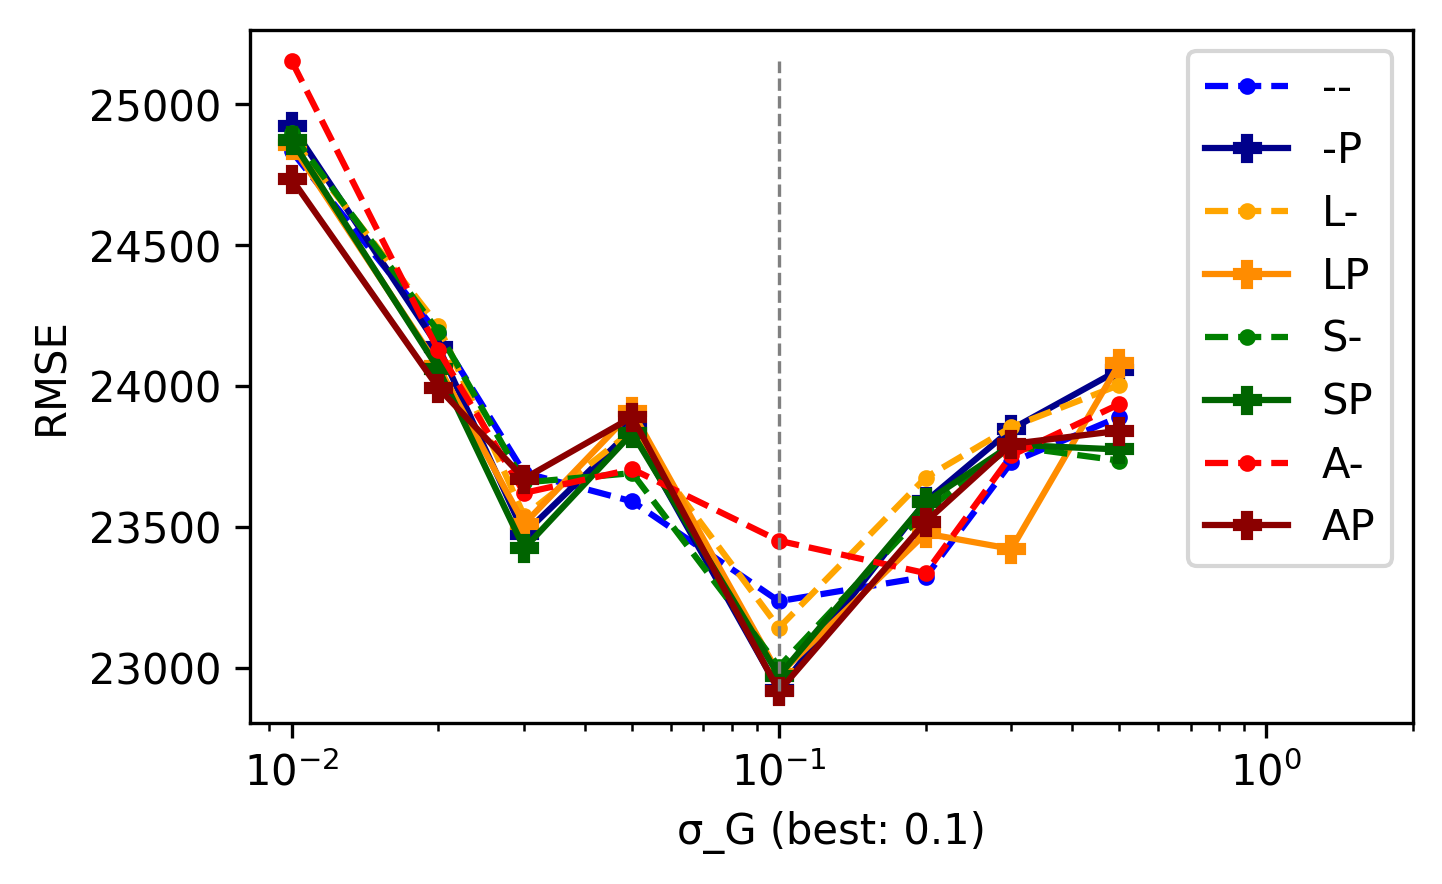

/tmp/ipykernel_1334789/407131956.py:36: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.0, 2)


best_sigma2: 0.03


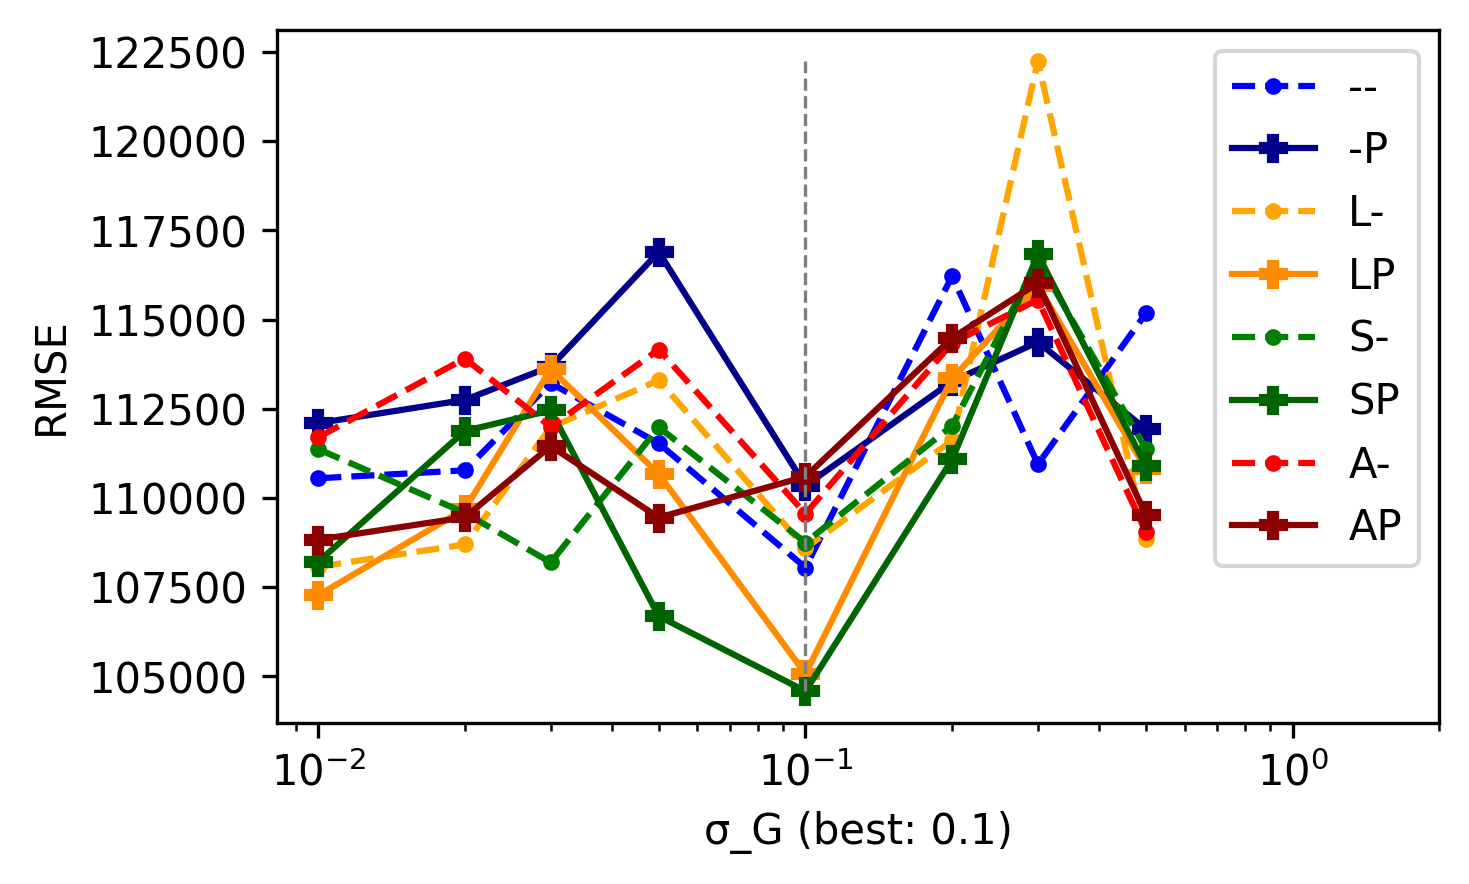

/tmp/ipykernel_1334789/407131956.py:36: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.0, 2)


best_sigma2: 0.01


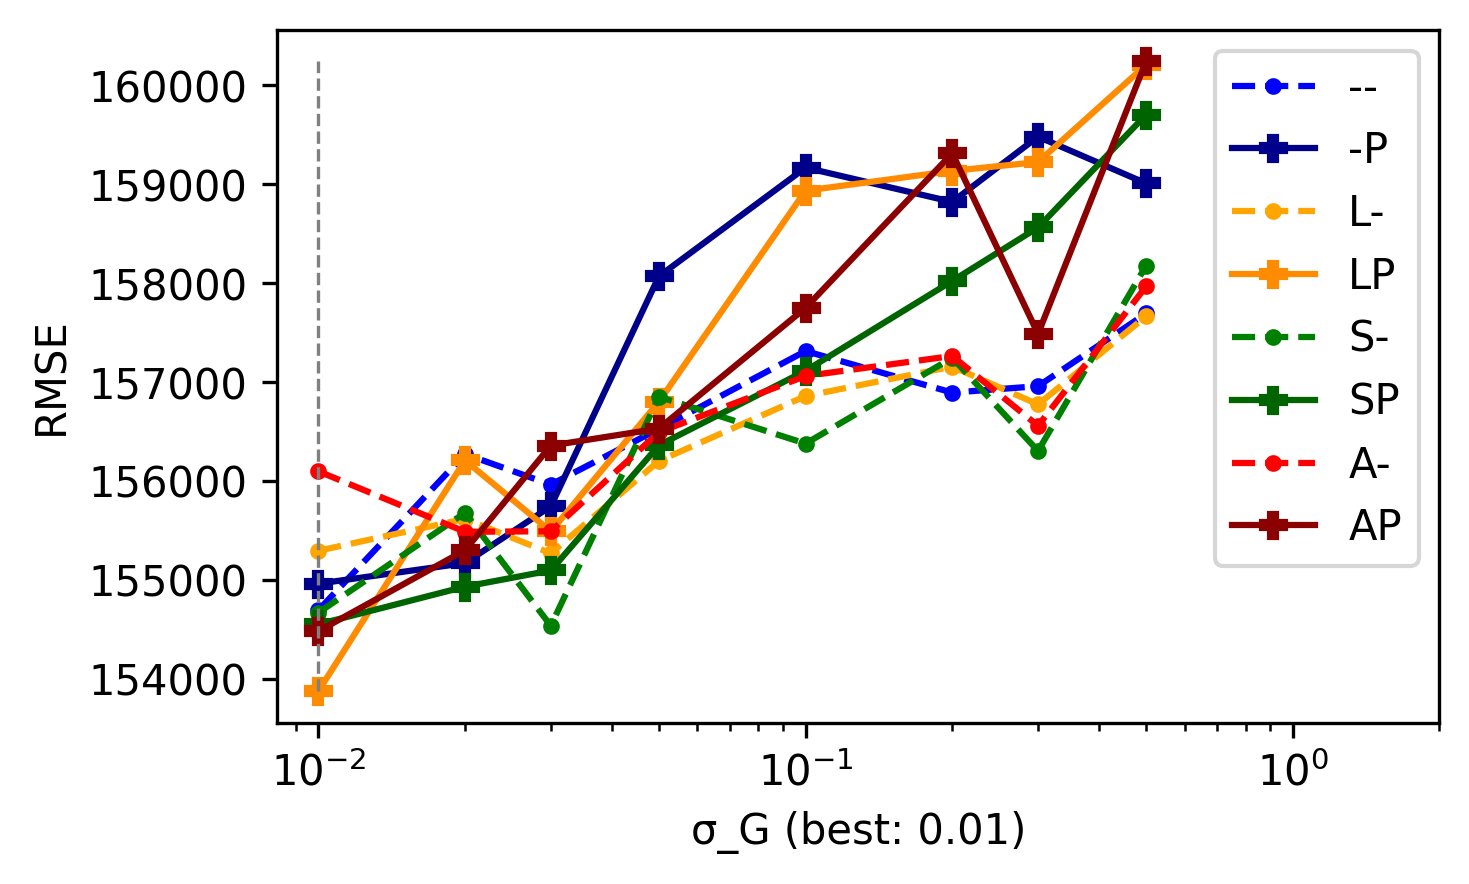

/tmp/ipykernel_1334789/407131956.py:36: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.0, 2)


best_sigma2: 0.01


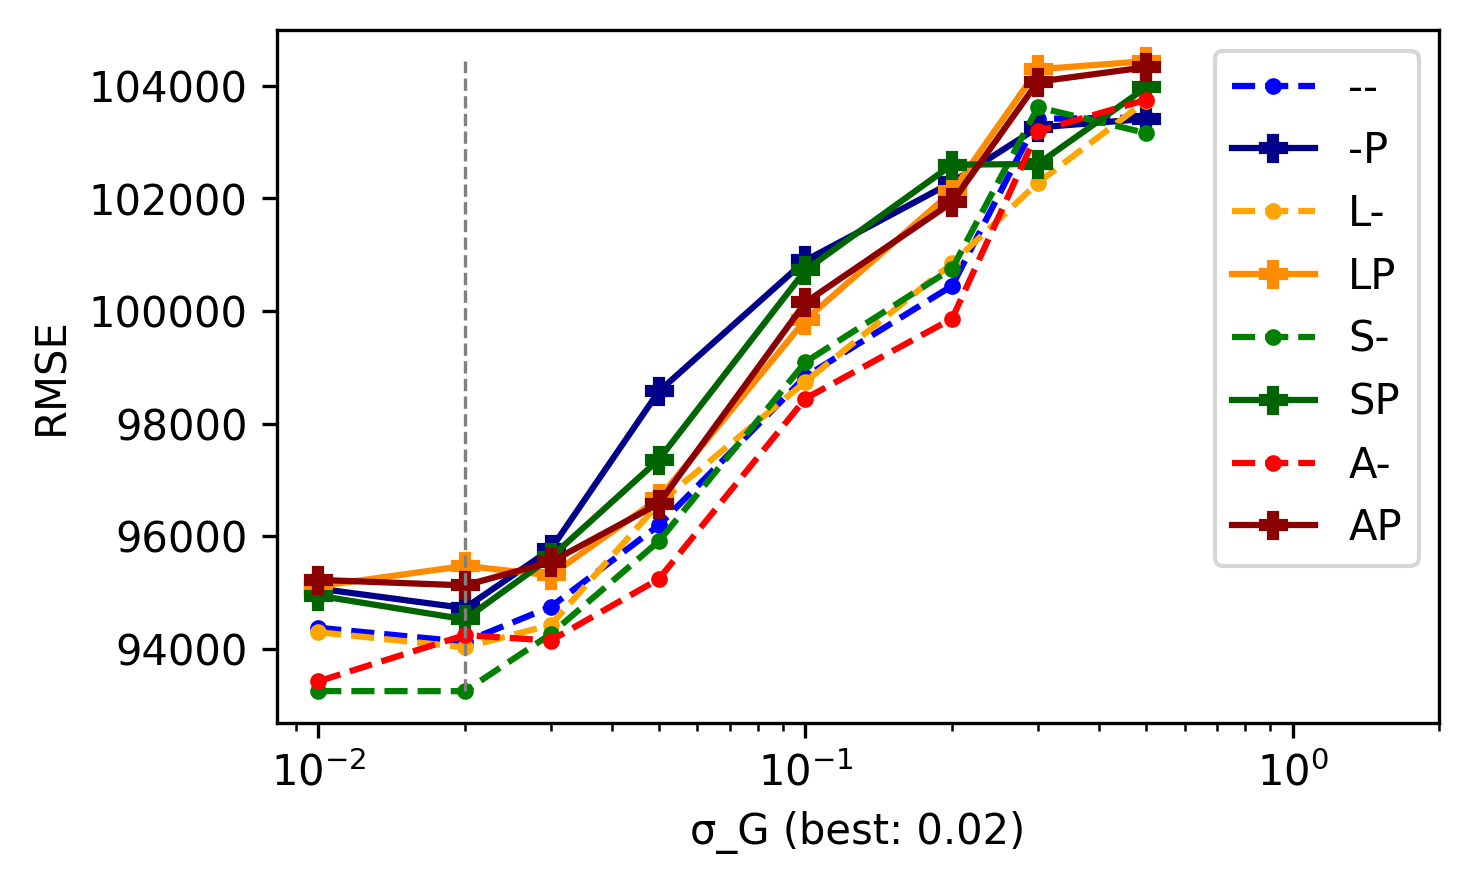

In [405]:

color_lines = [
    ('blue', '--'),
    ('darkblue', '-'),
    ('orange', '--'),
    ('darkorange', '-'),
    ('green', '--'),
    ('darkgreen', '-'),
    ('red', '--'),
    ('darkred', '-'),
]





for dname, vv in zip(datasets, [0.1, 0.1, 0.01, 0.02]):
    fig, ax = plt.subplots(figsize=(5, 3))
    vv = best_sigma[dname]
    
    minval = np.inf
    maxval = -np.inf
    for col, cl in zip(['--', '-P', 'L-', 'LP', 'S-', 'SP', 'A-', 'AP'], color_lines):
        if col[1] == 'P':
            m = 'P'
        else:
            m = '.'
        df_dict[dname][col].plot(ax=ax, marker=m, color=cl[0], linestyle=cl[1])
        for kv in df_dict[dname][col].values:
            if kv < minval:
                minval = kv
            if kv > maxval:
                maxval = kv
                
    #df_dict[dname][['--', '-P', 'L-', 'LP', 'S-', 'SP', 'A-', 'AP']].plot(ax=ax, marker='.')
    plt.xscale('log')
    plt.xlim(0.0, 2)
    
    plt.ylabel('RMSE')
    plt.legend(loc='upper right')
    plt.vlines(vv, minval, maxval, linewidth=.8, linestyle='--', color='gray')
    plt.xlabel(f'σ_G (best: {vv})')
    #plt.title(dname)
    print('best_sigma2:', best_sigma2[dname])

    # Show the figure

    # Set a higher DPI value (e.g., 300)
    fig.set_dpi(300)

    # Save the figure with high resolution
    fig.savefig(f'ablation_{dname}.png', dpi=300,bbox_inches='tight')
    plt.show()

In [154]:
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# # Create the figure and axes
# fig, axs = plt.subplots(len(datasets), len(models), figsize=(12, 9), sharex=True, sharey=True)

# # Iterate over datasets and models
# for i, dataset in enumerate(datasets):
#     ground_truth = np.load(f'./{dataset}/ground_truth.npy')
#     for j, model in enumerate(models):
#         # Generate random data for each ablation setting
#         ablations_style = []
#         if model == 'MyUAGCRN' or model == 'MyUAGCTransformer':
#             ablations = []
#             ablations_name = []
#             ablations_style = []
#             for g, a, s in reversed([('legacy', 'none', 'none'),
#                             ('cooccur_dist', 'none', 'none'),
#                             ('legacy', 'AE', 'SE'),
#                             ('cooccur_dist', 'AE', 'SE')]):
#                 ablations.append((g, a, s))

#                 aname = []
#                 if g == 'legacy':
#                     aname.append('legacy')
#                     astyle = '--'
#                 else:
#                     aname.append('ourgraph')
#                     astyle = '-'

#                 acolor = 'gray'
#                 if a == 'AE':
#                     aname.append('AE')
#                     acolor = 'red'
#                 if s == 'SE':
#                     aname.append('SE')
#                     acolor = 'green'
#                 if a == 'AE' and s == 'SE':
#                     acolor = 'blue'

#                 aname = '+'.join(aname)
#                 if len(aname) == 0:
#                     aname = 'none'
#                 ablations_name.append(aname)
#                 ablations_style.append((acolor, astyle))

#         elif model == 'MyARLSTM' or model == 'MyTransformer':
#             ablations = []
#             ablations_name = []
#             ablations_style = []
#             for a in ['AE', 'none']:
#                 for s in ['SE', 'none']:
#                     ablations.append(('none', a, s))

#                     aname = []
#                     astyle = '-'
#                     acolor = 'gray'
#                     if a == 'AE':
#                         aname.append('AE')
#                         acolor = 'red'
#                     if s == 'SE':
#                         aname.append('SE')
#                         acolor = 'green'
#                     if a == 'AE' and s == 'SE':
#                         acolor = 'blue'

#                     aname = '+'.join(aname)
#                     if len(aname) == 0:
#                         aname = 'none'
#                     ablations_name.append(aname)
#                     ablations_style.append((acolor, astyle))
#         else:
#             ablations = []
#             ablations_name = []

#         if dataset != 'pemsd7':
#             maxQ = 12
#         else:
#             maxQ = 9

# #         x = np.arange(1, maxQ + 1)
#         x = np.arange(1, 3 + 1)
#         y = []
#         for g, a, s in ablations:
#             fname = f'./{dataset}/{dataset}_{model}_G-{g}_AE-{a}_SE-{s}.npy'

#             try:
#                 if fname in fname2eval:
#                     evals = fname2eval[fname]
#                 else:
#                     prediction = np.load(fname)
#                     evals = []
#                     for Q in range(maxQ):
#                         vvv = metric(ground_truth[:, Q, ...], prediction[:, Q, ...])
#                         evals.append(vvv[1])
                    
#                     fname2eval[fname] = evals
#             except:
#                 print('not exist:', fname)
#                 pass
            
#             if maxQ == 12:
#                 y.append([evals[2], evals[5], evals[11]])
#             elif maxQ == 9:
#                 y.append([evals[2], evals[5], evals[ 8]])
                
# #         print(y)

#         # Plot the data
#         ax = axs[i, j]
#         bar_width = 0.15
#         opacity = 0.8
#         colors = ['blue', 'red', 'green', 'orange', 'purple']

#         ax.bar(x, dcrnn_metric[dataset], bar_width, alpha=opacity, color='black', label='DCRNN')
#         for k in range(len(ablations)):
#             ax.bar(x + ((k+1) * bar_width), y[k], bar_width, alpha=opacity, color=colors[k], label=ablations_name[k])

#         ax.set(xticks=list(range(1, 3+1)), ylim=(2, 10))
#         ax.set_title(model2title[model])
#         ax.legend( loc='upper left')
# #         ax.legend()

#         fig.tight_layout()

# # Add a common x-axis label and a legend
# # fig.text(0.5, 0.04, 'Q', ha='center', fontsize=14)
# # fig.legend(bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=len(ablations))

# # Set the overall title
# # fig.suptitle('Evaluation Results', fontsize=16)

# # Show the figure
# plt.show()

# # Set a higher DPI value (e.g., 300)
# fig.set_dpi(300)

# # Save the figure with high resolution
# fig.savefig('figure_high_resolution.png', dpi=300)